In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import datetime

import xesmf as xe
import scipy.signal as signal
import scipy.stats as st
import xgcm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib as mpl
import cartopy.crs as ccrs
import cmocean
import cmaps

from glob import glob
import sys
sys.path.append('../')
from utils import *
from load import *
from numerics import *
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=15, threads_per_worker=1)
client  = Client(cluster, asynchronous=True)
client


2023-05-03 14:42:45,385 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-c3stn9rh', purging
2023-05-03 14:42:45,386 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-g7cqdcwx', purging
2023-05-03 14:42:45,386 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-chaw6d57', purging
2023-05-03 14:42:45,386 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-9y4qhl1c', purging
2023-05-03 14:42:45,386 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-5fye4wmo', purging
2023-05-03 14:42:45,387 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-k7fc8110', purging
2023-05-03 14:42:45,387 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-gqsqvzpf', purging

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 15
Total threads: 15,Total memory: 93.09 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42745,Workers: 15
Dashboard: http://127.0.0.1:8787/status,Total threads: 15
Started: Just now,Total memory: 93.09 GiB
Comm: tcp://127.0.0.1:37839,Total threads: 1
Dashboard: http://127.0.0.1:32811/status,Memory: 6.21 GiB
Nanny: tcp://127.0.0.1:38097,


In [2]:
import geopandas as gpd
coastline = gpd.read_file('~/storage/VECTORIAL/limites/chilecontinental.gpkg')

# Load grid
gridd1 = xr.open_dataset('~/storage/SEQUIA/crocod1_grd.nc').load()

variables = ['salt_rate','salt_forc','salt_vmix','salt_hmix','salt_vadv','salt_xadv','salt_yadv']

/home/lucasg/miniconda3/envs/main/lib/python3.8/site-packages/geopandas/geodataframe.py:639: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [3]:
# Grab closest pixel to coast sea level time series and total column depth
h_coast           = xr.concat([gridd1.xi_rho.where(gridd1.mask_rho==1).isel(eta_rho=e).dropna('xi_rho').isel(xi_rho=-1) for e in range(len(gridd1.eta_rho))], 'eta_rho')

In [4]:
# Load control simulation 
pathsdia_control = sorted(glob('data/DESALADORAS_RUND1/*dia*'))
control_dia      = xr.open_mfdataset(pathsdia_control, parallel=True)[variables]
control_dia      = fix_crocotime(control_dia, YORIG='1949-12-30 23:59:50')
# control_dia      = center_crocogrid(control_dia, control_dia.keys())

In [5]:
# Load virtual river simulation
pathsdia_rivers = sorted(glob('data/DESALADORAS_RUND1_RIOS/*dia*'))
rivers_dia      = xr.open_mfdataset(pathsdia_rivers, parallel=True)[variables]
rivers_dia      = fix_crocotime(rivers_dia, YORIG='1949-12-30 23:59:50')
# rivers_dia      = center_crocogrid(rivers_dia, rivers_dia.keys())

In [6]:
control_diasurf = control_dia.isel(s_rho=-1).load()
rivers_diasurf  = rivers_dia.isel(s_rho=-1).load()

In [7]:
control_diabot = control_dia.isel(s_rho=0).load()
rivers_diabot  = rivers_dia.isel(s_rho=0).load()

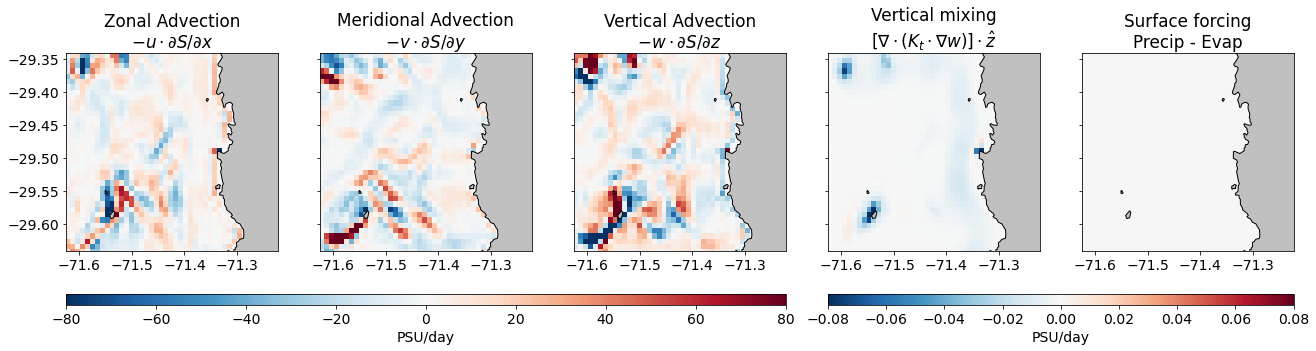

In [32]:
plt.rc('font',size=14)
fig, ax = plt.subplots(1,5, sharex=True, sharey=True, figsize=(22,15))
x = rivers_diabot.mean('time')
x.coords['lon_rho']=(x.lon_rho+180)%360-180

norm1 = mcolors.Normalize(-80,80)
norm2 = mcolors.Normalize(-0.08, 0.08)
m1=(x.salt_xadv*3600*24).plot(ax=ax[0], add_colorbar=False, norm=norm1, x='lon_rho', y='lat_rho', zorder=0, cmap='RdBu_r')
(x.salt_yadv*3600*24).plot(ax=ax[1], add_colorbar=False, norm=norm1, x='lon_rho', y='lat_rho', zorder=0, cmap='RdBu_r')
(x.salt_vadv*3600*24).plot(ax=ax[2], add_colorbar=False, norm=norm1, x='lon_rho', y='lat_rho', zorder=0, cmap='RdBu_r')
(x.salt_vmix*3600*24).plot(ax=ax[3], add_colorbar=False, norm=norm2, x='lon_rho', y='lat_rho', zorder=0, cmap='RdBu_r')
m2=(x.salt_forc*3600*24).plot(ax=ax[4], add_colorbar=False, norm=norm2, x='lon_rho', y='lat_rho', zorder=0, cmap='RdBu_r')

titles=['Zonal Advection\n'+r'$-u\cdot \partial S/\partial x$',
        'Meridional Advection\n'+r'$-v\cdot \partial S/\partial y$',
        'Vertical Advection\n'+r'$-w\cdot \partial S/\partial z$',
        'Vertical mixing\n'+r'$[\nabla \cdot (K_{t} \cdot \nabla w)] \cdot \hat{z}$',
        'Surface forcing\n'+r'Precip - Evap']
for i,axis in enumerate(ax.ravel()):
    coastline.plot(ax=axis, color='silver', ec='k', zorder=1)
    # axis.set_ylim(-32,-28.2)
    # axis.set_xlim(-72.5,-71.1)
    
    p = (-29.4909, -71.324)
    axis.set_ylim(p[0]-0.15,p[0]+0.15)
    axis.set_xlim(p[1]-0.3,p[1]+0.1)
    axis.set_title('')
    axis.set_xlabel('')
    axis.set_ylabel('')
    axis.set_title(titles[i])
    # axis.set_xlim()
    
box1 = ax[0].get_position()
box2 = ax[2].get_position()
box3 = ax[3].get_position()
box4 = ax[4].get_position()

cax1 = fig.add_axes([box1.xmin, box1.ymin-0.05, box2.xmax-box1.xmin, 0.01])
cax2 = fig.add_axes([box3.xmin, box3.ymin-0.05, box4.xmax-box3.xmin, 0.01])

fig.colorbar(m1, cax=cax1, orientation='horizontal', label='PSU/day')
fig.colorbar(m2, cax=cax2, orientation='horizontal', label='PSU/day')


In [90]:
control_totoralillo = control_diabot.sel(eta_rho=406, xi_rho=126).load()*3600*24
control_panul       = control_diabot.sel(eta_rho=341, xi_rho=117).load()*3600*24
control_losvilos    = control_diabot.sel(eta_rho=105, xi_rho=107).load()*3600*24


rivers_totoralillo  = rivers_diabot.sel(eta_rho=406, xi_rho=126).load()*3600*24
rivers_panul        = rivers_diabot.sel(eta_rho=406, xi_rho=126).load()*3600*24
rivers_losvilos     = rivers_diabot.sel(eta_rho=406, xi_rho=126).load()*3600*24

array([[<AxesSubplot:xlabel='month'>, <AxesSubplot:xlabel='month'>,
        <AxesSubplot:xlabel='month'>, <AxesSubplot:xlabel='month'>,
        <AxesSubplot:xlabel='month'>, <AxesSubplot:xlabel='month'>,
        <AxesSubplot:xlabel='month'>, <AxesSubplot:xlabel='month'>,
        <AxesSubplot:xlabel='month'>]], dtype=object)

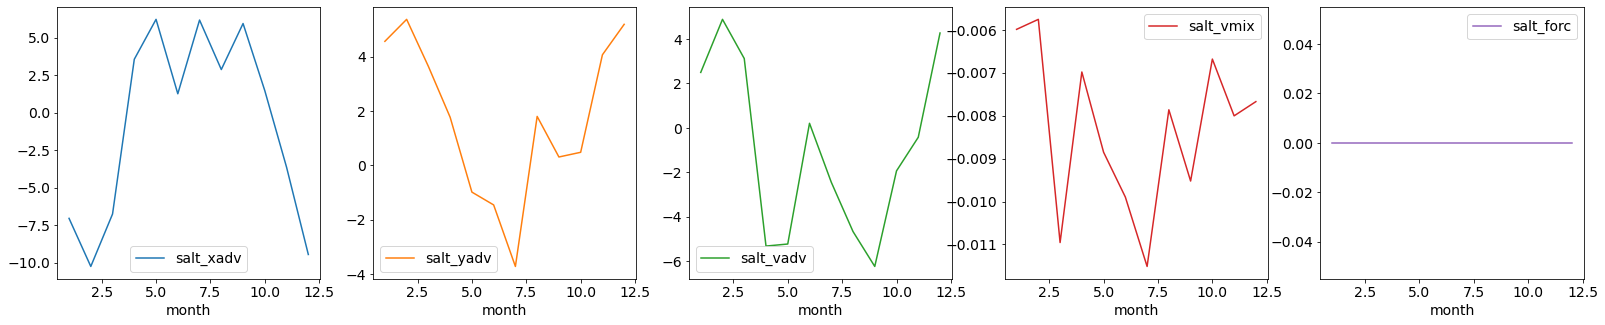

In [127]:
control_totoralillo.groupby('time.month').mean().to_dataframe()[['salt_xadv','salt_yadv','salt_vadv','salt_vmix','salt_forc']].plot(subplots=True, figsize=(50,5), layout=(1,9))

[Text(0, 0, 'Total Advection\n$-\\vec{u}\\cdot \\nabla S$'),
 Text(1, 0, 'Vertical mixing\n$[\\nabla \\cdot (K_{t} \\cdot \\nabla w)] \\cdot \\hat{z}$'),
 Text(2, 0, 'Surface forcing\nPrecip - Evap')]

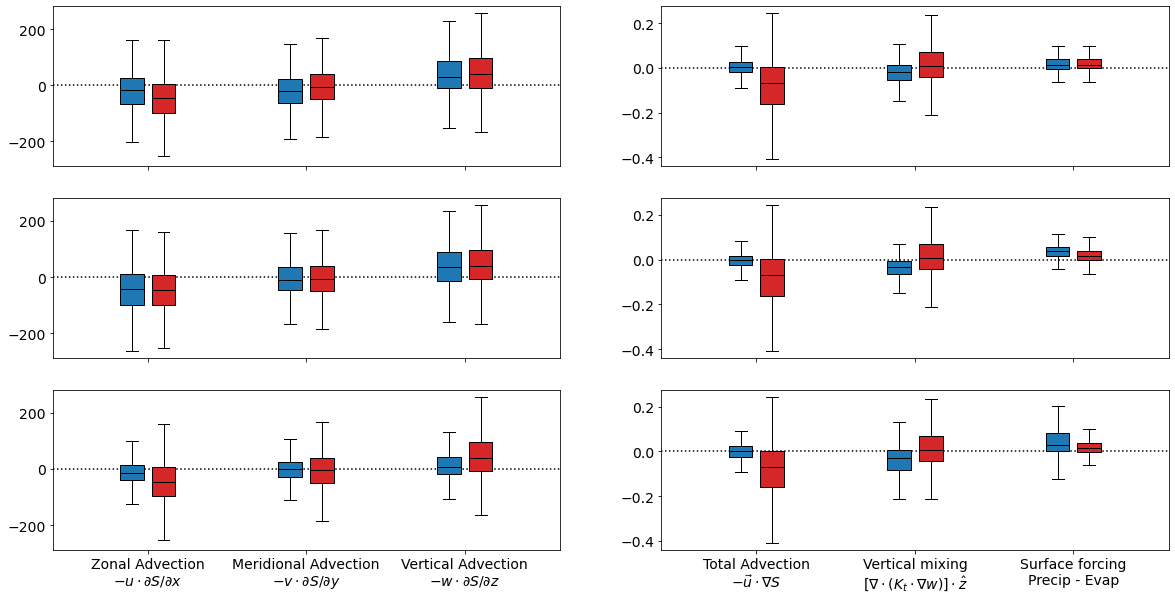

In [86]:
fig, ax = plt.subplots(3,2, sharex='col', sharey='col', figsize=(20,10))

for i,v in enumerate(['totoralillo', 'panul', 'losvilos']):
    ax[i,0].axhline(0, color='k', ls=":")
    ax[i,-1].axhline(0, color='k', ls=":")
    control = eval('control_'+v)
    control['salt_tadv'] = control.salt_xadv+control.salt_yadv+control.salt_vadv
    control['salt_hadv'] = control.salt_xadv+control.salt_yadv
    
    rivers  = eval('rivers_'+v)
    rivers['salt_tadv'] = rivers.salt_xadv+rivers.salt_yadv+rivers.salt_vadv
    rivers['salt_hadv'] = rivers.salt_xadv+rivers.salt_yadv
    
    for m,val in enumerate(['salt_xadv','salt_yadv','salt_vadv']):
        ax[i,0].boxplot(control[val], positions=[m-0.1], sym='', patch_artist=True, medianprops={'color':'k'}, boxprops={'facecolor':'tab:blue'})
        ax[i,0].boxplot(rivers[val], positions=[m+0.1], sym='', patch_artist=True, medianprops={'color':'k'}, boxprops={'facecolor':'tab:red'})
    
    for m,val in enumerate(['salt_tadv','salt_vmix','salt_forc']):
        ax[i,1].boxplot(control[val], positions=[m-0.1], sym='', patch_artist=True, medianprops={'color':'k'}, boxprops={'facecolor':'tab:blue'})
        ax[i,1].boxplot(rivers[val], positions=[m+0.1], sym='', patch_artist=True, medianprops={'color':'k'}, boxprops={'facecolor':'tab:red'})
    
ax[-1,0].set_xticks([0,1,2])
ax[-1,0].set_xticklabels(['Zonal Advection\n'+r'$-u\cdot \partial S/\partial x$','Meridional Advection\n'+r'$-v\cdot \partial S/\partial y$','Vertical Advection\n'+r'$-w\cdot \partial S/\partial z$',])

ax[-1,-1].set_xticks([0,1,2])
ax[-1,-1].set_xticklabels(['Total Advection\n'+r'$-\vec{u}\cdot \nabla S$','Vertical mixing\n'+r'$[\nabla \cdot (K_{t} \cdot \nabla w)] \cdot \hat{z}$','Surface forcing\n'+r'Precip - Evap'])
    


[Text(0, 0, 'Total Advection\n$-\\vec{u}\\cdot \\nabla S$'),
 Text(1, 0, 'Vertical mixing\n$[\\nabla \\cdot (K_{t} \\cdot \\nabla w)] \\cdot \\hat{z}$'),
 Text(2, 0, 'Surface forcing\nPrecip - Evap')]

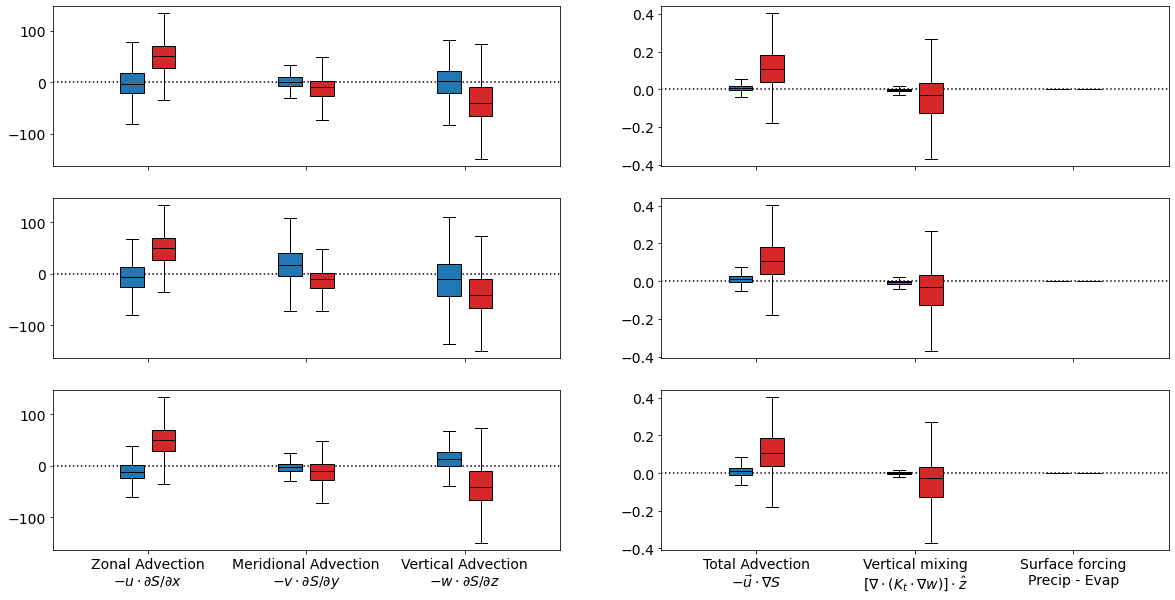

In [95]:
fig, ax = plt.subplots(3,2, sharex='col', sharey='col', figsize=(20,10), facecolor='w')

for i,v in enumerate(['totoralillo', 'panul', 'losvilos']):
    ax[i,0].axhline(0, color='k', ls=":")
    ax[i,-1].axhline(0, color='k', ls=":")
    
    control = eval('control_'+v)
    control['salt_tadv'] = control.salt_xadv+control.salt_yadv+control.salt_vadv
    control['salt_hadv'] = control.salt_xadv+control.salt_yadv
    
    rivers  = eval('rivers_'+v)
    rivers['salt_tadv'] = rivers.salt_xadv+rivers.salt_yadv+rivers.salt_vadv
    rivers['salt_hadv'] = rivers.salt_xadv+rivers.salt_yadv
    
    for m,val in enumerate(['salt_xadv','salt_yadv','salt_vadv']):
        ax[i,0].boxplot(control[val], positions=[m-0.1], sym='', patch_artist=True, medianprops={'color':'k'}, boxprops={'facecolor':'tab:blue'})
        ax[i,0].boxplot(rivers[val], positions=[m+0.1], sym='', patch_artist=True, medianprops={'color':'k'}, boxprops={'facecolor':'tab:red'})
    
    for m,val in enumerate(['salt_tadv','salt_vmix','salt_forc']):
        ax[i,1].boxplot(control[val], positions=[m-0.1], sym='', patch_artist=True, medianprops={'color':'k'}, boxprops={'facecolor':'tab:blue'})
        ax[i,1].boxplot(rivers[val], positions=[m+0.1], sym='', patch_artist=True, medianprops={'color':'k'}, boxprops={'facecolor':'tab:red'})
    
ax[-1,0].set_xticks([0,1,2])
ax[-1,0].set_xticklabels(['Zonal Advection\n'+r'$-u\cdot \partial S/\partial x$','Meridional Advection\n'+r'$-v\cdot \partial S/\partial y$','Vertical Advection\n'+r'$-w\cdot \partial S/\partial z$',])

ax[-1,-1].set_xticks([0,1,2])
ax[-1,-1].set_xticklabels(['Total Advection\n'+r'$-\vec{u}\cdot \nabla S$','Vertical mixing\n'+r'$[\nabla \cdot (K_{t} \cdot \nabla w)] \cdot \hat{z}$','Surface forcing\n'+r'Precip - Evap'])
    
